# ADHunter on Sog1 data

In [1]:
%load_ext autoreload
%autoreload 2 

%matplotlib inline

import os
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

from sklearn import preprocessing
import pytorch_lightning as pl
from actpred.models import ActCNNSystem
from actpred.utils import get_threshold, get_stratified_split

from scipy.stats import spearmanr, pearsonr
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, WandbLogger

pl.seed_everything(0)
os.chdir("../adhunter")

Global seed set to 0


In [2]:
# CHANGE TO POINT TO PATH ON YOUR COMPUTER!!!!
fn = "../data/sog1/all_shuffle_vars_JD.csv"

sog1_df = pd.read_csv(fn, index_col=0)
# Extract WT activations
wt_df = (pd.DataFrame(
    sog1_df
    .groupby("tile_wt")["Activity_S3_1_wt"]
    .unique())
    .reset_index()
    .rename(
        columns={"tile_wt": "Seq", "Activity_S3_1_wt": "Activity"}
    ))
wt_df["Activity"] = np.hstack(wt_df["Activity"].values)
# Extract activations from shuffled sequences
shuffled_df = (sog1_df[["tile_var", "Activity_S3_1_var"]]
 .copy()
 .rename(
     columns={"tile_var": "Seq", "Activity_S3_1_var": "Activity"}
 ))
df = (
    pd.concat([shuffled_df, wt_df], keys=['shuffled', 'wt'], names=["type"])
    .reset_index()
    .drop("level_1", axis=1))
df["Activity"] = df["Activity"].fillna(0.0)
df = df.loc[df.Activity != 0.0]
# df = df.iloc[:, 1:]
# df = df.loc[df.loc[:, ['Seq', 'Activity']].drop_duplicates().index]
# 
df = df.dropna(subset=df.columns[:-1], axis=0)

# Use the df to calculate train test splits
seqs = df["Seq"].to_numpy()
activity = df["Activity"].to_numpy()
# thresh = 80_000
# # get binary labels based on threshold
# y_bin = (activity >= thresh).astype(np.int64).reshape(-1, 1)

# scale data to have mean 0 and variance 1
y_cont = activity.reshape(-1, 1)
scaler = preprocessing.StandardScaler().fit(y_cont)
y_cont = scaler.transform(y_cont)
y_cont = torch.tensor(y_cont)


# convert seqs to integer valued vectors
alphabet="ACDEFGHIKLMNPQRSTVWY"
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
i_to_aa = {i:aa for i, aa in enumerate(alphabet)}
X = torch.tensor(np.asarray([[aa_to_i[aa] for aa in x] for x in seqs]))

# train, val, test, indices = get_stratified_split(X, y_bin, y_cont, as_tensor=True)
# (X_train, y_bin_train, y_cont_train) = train
# (X_val, y_bin_val, y_cont_val) = val
# (X_test, y_bin_test, y_cont_test) = test
# test_idx, val_idx = indices

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y_cont, train_size=0.8, random_state=43)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, train_size=0.5, random_state=43)

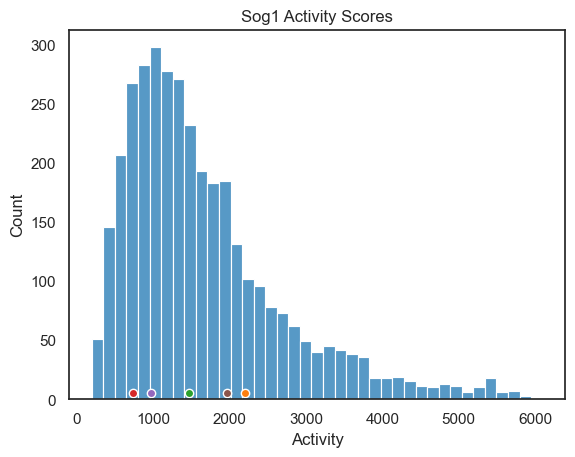

In [4]:
sns.histplot(df, x="Activity",)
for i in wt_df["Activity"]:
    plt.scatter(i, 5, edgecolors='w')
plt.title("Sog1 Activity Scores")
plt.show()

In [5]:
# Create Training and Validation Datasets
pl.seed_everything(0)

bs = 128
train_ds = TensorDataset(X_train, y_train.to(torch.float))
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

val_ds = TensorDataset(X_val, y_val.to(torch.float))
val_dl = DataLoader(val_ds, batch_size=bs)

Global seed set to 0


In [6]:
# Train Model
kernel_size = 5
dilation = 3 
hidden = 64

model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3, one_hot=True)
dirpath="models"
csv_logger = CSVLogger('logs')
checkpoint_callback = ModelCheckpoint(dirpath=dirpath, monitor="val_loss", filename="min_val_loss", save_last=True)
patience=10
early_stopping = EarlyStopping('val_loss', patience=patience)

trainer = pl.Trainer(accelerator="gpu", devices=1, callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=100)
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)


/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNN           | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0     
3 | pearsonr  | PearsonCorrCoef  | 0     
4 | spearma

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 36.38it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


val_rmse 0.9870693683624268
val_pearsonr 0.012115474790334702
val_spearmanr 0.05889653041958809


/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 26/26 [00:00<00:00, 41.06it/s, loss=1.04, v_num=49]val_rmse 1.0091458559036255
val_pearsonr -0.0033015303779393435
val_spearmanr -0.021658044308423996
Epoch 1: 100%|██████████| 26/26 [00:00<00:00, 77.41it/s, loss=0.956, v_num=49]val_rmse 1.0278407335281372
val_pearsonr -0.01838993839919567
val_spearmanr 0.0003066649369429797
Epoch 2: 100%|██████████| 26/26 [00:00<00:00, 64.00it/s, loss=0.917, v_num=49]val_rmse 1.0090851783752441
val_pearsonr 0.09723084419965744
val_spearmanr 0.09483712911605835
Epoch 3: 100%|██████████| 26/26 [00:00<00:00, 75.70it/s, loss=0.917, v_num=49]val_rmse 1.0252037048339844
val_pearsonr 0.09074540436267853
val_spearmanr 0.09466131776571274
Epoch 4: 100%|██████████| 26/26 [00:00<00:00, 83.69it/s, loss=0.79, v_num=49] val_rmse 1.0170915126800537
val_pearsonr 0.07578198611736298
val_spearmanr 0.07763729244470596
Epoch 5: 100%|██████████| 26/26 [00:00<00:00, 71.85it/s, loss=0.747, v_num=49]val_rmse 1.0369060039520264
val_pearsonr 0.0741837

In [7]:
# get best model and save it
model = model.load_from_checkpoint(checkpoint_callback.best_model_path)
# torch.save(model.cpu().state_dict(), "adhunter_1he.pt")

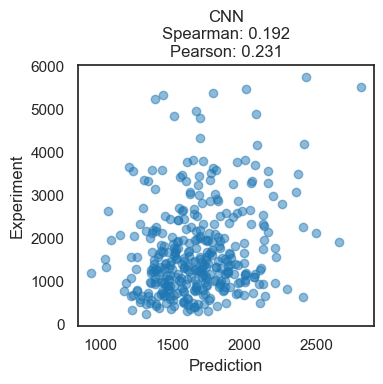

In [22]:
test_ds = TensorDataset(X_test, y_test.to(torch.float))
test_dl = DataLoader(test_ds, batch_size=bs)

model.eval()
X_test, y_te = test_ds[:]
y_te = y_te.reshape(-1)
with torch.no_grad():
    y_test_hat = model(X_test).reshape(-1)
    y_test_hat = y_test_hat.detach().numpy()
    y_te = y_te.numpy()

# best_thresh = get_threshold(y_bin_test, y_test_hat)
# best_thresh_unscaled = scaler.inverse_transform(np.asarray([best_thresh]).reshape(-1, 1)).item()
# y_test_hat_bin = (y_test_hat > best_thresh).astype(np.int32)

y_test_hat_unscaled = scaler.inverse_transform(y_test_hat.reshape(-1, 1)).reshape(-1)
y_test_unscaled = scaler.inverse_transform(y_te.reshape(-1, 1)).reshape(-1)


def plot_corr():
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.scatter(y_test_hat_unscaled, y_test_unscaled, alpha=0.5)
    scorr = spearmanr(y_test_hat_unscaled, y_test_unscaled).correlation
    pcorr = pearsonr(y_test_hat_unscaled, y_test_unscaled).correlation
    ax.set(xlabel="Prediction", ylabel="Experiment", title=f"CNN\nSpearman: {scorr:.3f}\nPearson: {pcorr:.3f}")
    plt.tight_layout()
    plt.show()
    return scorr, pcorr

scorr, pcorr = plot_corr()
# plot_corr("pearson")

# Regressions
ADHunter doesn't work well on this data. Are regressions much better?

In [18]:
import re
from itertools import product
np.char.count(seqs[0], "AA"), seqs[0]
count_kmers = lambda seq, pair: seq.count(pair)
dipeptides = ["".join(j) for j in [i for i in product(alphabet, repeat=2)]]
# dipeptides = ["".join(j) for j in [i for i in combinations(alphabet, 2)]]
get_input_2mers = lambda seq: np.array([count_kmers(seq, pair) for pair in dipeptides])
get_input_single = lambda seq: np.array([count_kmers(seq, aa) for aa in alphabet])
# Additional functions to double count where applicable: eg AAAA -> 4 AA instead of 2 AA
count_kmers_all = lambda seq, pair: len(re.findall(f'(?=({pair}))', seq))
get_input_2mers_all = lambda seq: np.array([count_kmers(seq, pair) for pair in dipeptides])

# X_2mers = np.vstack(df["Seq"].apply(get_input_2mers).values)
X_2mers = np.vstack(df["Seq"].apply(get_input_2mers_all).values)
X_aa = np.vstack(df["Seq"].apply(get_input_single).values)
X_combined = np.hstack([X_2mers, X_aa])

In [20]:
X_2mer_train, X_2mer_test, y_2mer_train, y_2mer_test = train_test_split(X_2mers, y_cont, train_size=.8)
X_aa_train, X_aa_test, y_aa_train, y_aa_test = train_test_split(X_aa, y_cont, train_size=.8)
X_comb_train, X_comb_test, y_comb_train, y_comb_test = train_test_split(X_combined, y_cont, train_size=.8)


In [21]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(X_2mer_train, y_2mer_train)
print(regr.score(X_2mer_test, y_2mer_test)) 

regr_single = LinearRegression()
regr_single.fit(X_aa_train, y_aa_train)
print(regr_single.score(X_aa_test, y_aa_test)) 

regr_comb = LinearRegression()
regr_comb.fit(X_comb_train, y_comb_train)
print(regr_comb.score(X_comb_test, y_comb_test)) 

-0.11727335985698861
0.0041260251984908125
-0.04121791457735191


/var/folders/1w/3zhjqj3d3ljgvrrqp77lpv6m0000gn/T/ipykernel_11088/2153745334.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot({


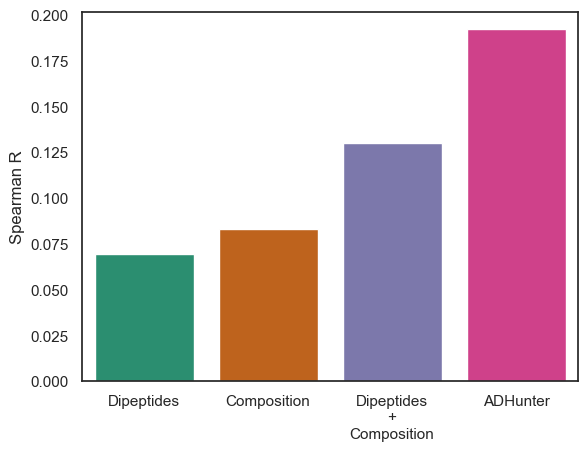

/var/folders/1w/3zhjqj3d3ljgvrrqp77lpv6m0000gn/T/ipykernel_11088/2153745334.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot({


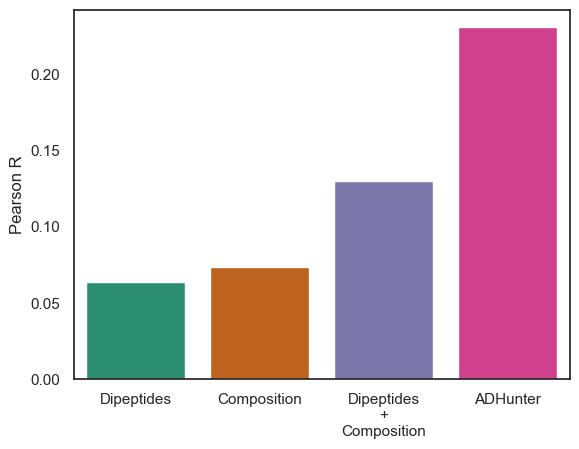

In [23]:
r_2mer, _ = spearmanr(regr.predict(X_2mer_test), y_2mer_test)
r_aa, _ = spearmanr(regr_single.predict(X_aa_test), y_aa_test)
r_comb, _ = spearmanr(regr_comb.predict(X_comb_test), y_comb_test)

sns.barplot({
    "Dipeptides": r_2mer, 
    "Composition": r_aa, 
    "Dipeptides\n+\nComposition": r_comb,
    "ADHunter": scorr,
    }, errorbar=None, palette='Dark2')
plt.ylabel("Spearman R")
plt.show()

r_2mer, _ = pearsonr(regr.predict(X_2mer_test).flatten(), y_2mer_test.flatten())
r_aa, _ = pearsonr(regr_single.predict(X_aa_test).flatten(), y_aa_test.flatten())
r_comb, _ = pearsonr(regr_comb.predict(X_comb_test).flatten(), y_comb_test.flatten())

sns.barplot({
    "Dipeptides": r_2mer, 
    "Composition": r_aa, 
    "Dipeptides\n+\nComposition": r_comb,
    "ADHunter": pcorr,
    }, errorbar=None, palette='Dark2')
plt.ylabel("Pearson R")
plt.show()